## Note : This Kernel is a Fork from the amazing Kernel below . So please upvote the original Kernel . I have started adding few information and preprocessing into this on my own . 
https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

## About The Competition : Detecting Steel Defect 

Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this competition will help identify defects.


Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry—and they take corporate responsibility seriously. The company recently created the country’s largest industrial data lake, with petabytes of data that were previously discarded. Severstal is now looking to machine learning to improve automation, increase efficiency, and maintain high quality in their production.

The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship. Today, Severstal uses images from high frequency cameras to power a defect detection algorithm.

In this competition, you’ll help engineers improve the algorithm by localizing and classifying surface defects on a steel sheet.

If successful, you’ll help keep manufacturing standards for steel high and enable Severstal to continue their innovation, leading to a stronger, more efficient world all around us.

 Reference :http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html
 
 In the Northeastern University (NEU) surface defect database, six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). 
 #### At a first look it seems for our images :  
1. Class 1 : Inclusion
2. Class 2: Pitted
3. Class 3 : Scratches 
4. Class 4 : Patches . 



However I  might be wrong :) . 
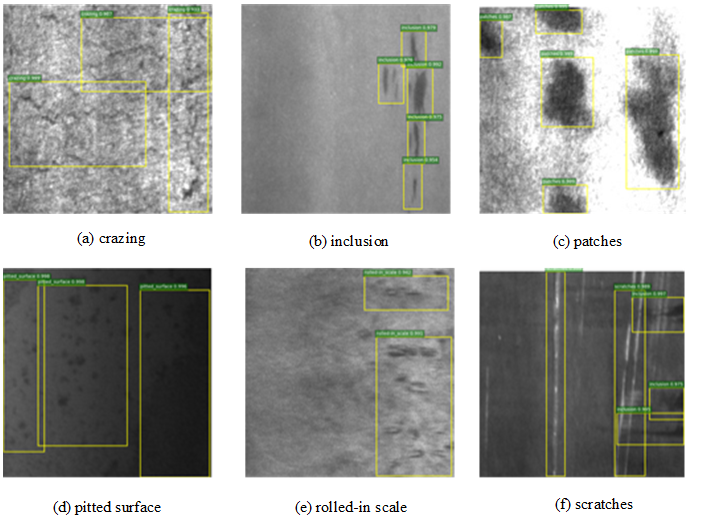




## import modules and define models

In [ ]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
print(os.listdir("../input"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
import PIL
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.morphology import label
from skimage.feature import hog
from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.feature import canny
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings("ignore")
from skimage.segmentation import mark_boundaries
from scipy import signal
import cv2
import glob, pylab, pandas as pd
import pydicom, numpy as np
import tqdm
import gc
gc.enable()
import glob

from skimage.transform import resize
from skimage.morphology import label
from skimage.feature import hog
from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.feature import canny
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings("ignore")
from skimage.segmentation import mark_boundaries

import sys


In [ ]:
input_dir = "../input/"

In [ ]:
train_df = pd.read_csv("../input/train.csv")
sample_df = pd.read_csv("../input/sample_submission.csv")

In [ ]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx] += 1

In [ ]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

* There are similar numbers of images with and without defects.
* class is imbalanced

### How many classes do each image have?

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

* almost image have no defect or one kind of defect

## check image data
### image size

In [ ]:
train_size_dict = defaultdict(int)
train_path = Path("../input/train_images/")

for img_name in train_path.iterdir():
    img = PIL.Image.open(img_name)
    train_size_dict[img.size] += 1

In [ ]:
train_size_dict

In [ ]:
test_size_dict = defaultdict(int)
test_path = Path("../input/test_images/")

for img_name in test_path.iterdir():
    img = PIL.Image.open(img_name)
    test_size_dict[img.size] += 1

In [ ]:
test_size_dict

* All image have same shape, (1600, 256).

# Let's visualization masks!

In [ ]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [ ]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, 3] = rgba[:,:,0] * 100
        rgba[:, :, :3] = rgba[:, :, :3] * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [ ]:
labels = train_df.iloc[5:5+4, 1]

In [ ]:
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos:(pos+le)] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [ ]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    #fig, ax = plt.subplots(figsize=(15, 15))
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)   
        for i, ctr in enumerate(contours):
            if i > 0 :
                break
        # Get bounding box
            x, y, w, h = cv2.boundingRect(ctr)
            
            # Getting ROI
            roi = img[y:y + h, x:x + w]
            print(roi.shape)
            res = cv2.resize(roi, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    ax[0].set_title(name)
    ax[0].imshow(img)
    ax[1].set_title('One ROI')
    ax[1].imshow(res)
    plt.show()


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [ ]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)


## images with defect(label: 1)

In [ ]:
for idx in idx_class_1[:1]:
    show_mask_image(idx)

## images with defect(label: 2)

In [ ]:
idx_class_2[:1]

In [ ]:
for idx in idx_class_2[:1]:
    show_mask_image(idx)

## images with defect(label: 3)

In [ ]:
for idx in idx_class_3[:1]:
    show_mask_image(idx)
    
    

## images with defect(label: 4)

In [ ]:
for idx in idx_class_4[:1]:
    show_mask_image(idx)

## images with defect(contain multi label)

In [ ]:
for idx in idx_class_multi[:4]:
    show_mask_image(idx)

## images with defect(contain 3 type label)

In [ ]:
for idx in idx_class_triple[:1]:
    show_mask_image(idx)

In [ ]:
#These are the functions provided by kaggle to convert a mask to rle and vice-versa.
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor: 
                if currentColor >= 127:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)


def rle2mask(rle, width, height):
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

#### Images with normal mask and Ben's processing 

In [ ]:
ImageId = '0002cc93b.jpg_1'
train_df.head()

img = cv2.imread('../input/train_images/' + ImageId.split('_')[0])
img_masks = train_df.loc[train_df['ImageId_ClassId'] == ImageId, 'EncodedPixels'].tolist()
p2, p97 = np.percentile(img, (2, 97))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p97))

img_ben = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0) , 10) ,-4 ,128)

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((256,1600))
for mask in img_masks:
    all_masks += rle2mask(mask,256,1600)
    
fig, axarr = plt.subplots(5, 1, figsize=(15, 15))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img_rescale)
#axarr[2].imshow(img_rescale)
axarr[3].imshow(all_masks, alpha=0.7)
axarr[4].imshow(img_ben)
plt.tight_layout(h_pad=0.4, w_pad=0.4)
plt.show()



In [ ]:
### Take the images with masks
train_masked_df = train_df[ train_df['EncodedPixels'].notnull() ]


#### Multiple Images with Ben's preprocessing 

In [ ]:
view_count =  15
#i_chk = np.random.randint(0,len(data), size = view_count)
sample_imgs = []
ben_sample_imgs = []
sample_imgs_label =[]
file_list = ['../input/train_images/{}'.format(train_masked_df['ImageId_ClassId'].values.tolist()[i].split('_')[0]) for i in range(view_count)]

for i in range(view_count) :
    sample_img = cv2.imread(file_list[i])
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
    sample_imgs.append(sample_img)
    sample_imgs_label.append(file_list[i])
    ben_sample_imgs.append(cv2.addWeighted (sample_img,4, cv2.GaussianBlur(sample_img, (0,0) , 10) ,-4 ,128))

In [ ]:
#plt.imshow(ben_sample_imgs[0])
plt.imshow(cv2.cvtColor(ben_sample_imgs[8],cv2.COLOR_RGB2GRAY))


In [ ]:
for i in range(5) :
    fig , ax = plt.subplots(1,2,figsize = (15,15))
    ax[0].imshow(sample_imgs[i])
    ax[1].imshow(ben_sample_imgs[i])
    #plt.autoscale(tight = 'True' , axis = 'y')
    ax[0].set_title(sample_imgs_label[i], y = 1)
    ax[1].set_title(str(sample_imgs_label[i]) + ' with preprocess', y = 1)
    ax[0].axis('off')
    ax[1].axis('off')

#### Augmentation functions in one place . Will use later . Not now 

In [ ]:
ben_sample_imgs[0].shape

In [ ]:
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter
from functools import wraps
import torch
import torchvision.transforms.functional as F


def vflip(img):
    return cv2.flip(img, 0)


def hflip(img):
    return cv2.flip(img, 1)


def random_flip(img, code):
    return cv2.flip(img, code)


def transpose(img):
    return img.transpose(1, 0, 2) if len(img.shape) > 2 else img.transpose(1, 0)


def rot90(img, factor):
    img = np.rot90(img, factor)
    return np.ascontiguousarray(img)


def rotate(img, angle):
    height, width = img.shape[0:2]
    mat = cv2.getRotationMatrix2D((width/2, height/2), angle, 1.0)
    img = cv2.warpAffine(img, mat, (width, height),
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)
    return img


def shift_scale_rotate(img, angle, scale, dx, dy):
    height, width = img.shape[:2]

    cc = math.cos(angle/180*math.pi) * scale
    ss = math.sin(angle/180*math.pi) * scale
    rotate_matrix = np.array([[cc, -ss], [ss, cc]])

    box0 = np.array([[0, 0], [width, 0],  [width, height], [0, height], ])
    box1 = box0 - np.array([width/2, height/2])
    box1 = np.dot(box1, rotate_matrix.T) + np.array([width/2+dx*width, height/2+dy*height])

    box0 = box0.astype(np.float32)
    box1 = box1.astype(np.float32)
    mat = cv2.getPerspectiveTransform(box0, box1)
    img = cv2.warpPerspective(img, mat, (width, height),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_REFLECT_101)

    return img


def center_crop(img, height, width):
    h, w, c = img.shape
    dy = (h-height)//2
    dx = (w-width)//2
    y1 = dy
    y2 = y1 + height
    x1 = dx
    x2 = x1 + width
    img = img[y1:y2, x1:x2, :]
    return img


def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)


def clipped(func):
    @wraps(func)
    def wrapped_function(img, *args, **kwargs):
        dtype, maxval = img.dtype, np.max(img)
        return clip(func(img, *args, **kwargs), dtype, maxval)
    return wrapped_function


def shift_hsv(img, hue_shift, sat_shift, val_shift):
    dtype = img.dtype
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.int32)
    h, s, v = cv2.split(img)
    h = cv2.add(h, hue_shift)
    h = np.where(h < 0, 255 - h, h)
    h = np.where(h > 255, h - 255, h)
    h = h.astype(dtype)
    s = clip(cv2.add(s, sat_shift), dtype, 255 if dtype == np.uint8 else 1.)
    v = clip(cv2.add(v, val_shift), dtype, 255 if dtype == np.uint8 else 1.)
    img = cv2.merge((h, s, v)).astype(dtype)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

@clipped
def shift_rgb(img, r_shift, g_shift, b_shift):
    img[...,0] = img[...,0] + r_shift
    img[...,1] = img[...,1] + g_shift
    img[...,2] = img[...,2] + b_shift
    return img

def clahe(img, clipLimit=2.0, tileGridSize=(8,8)):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_LAB2RGB)
    return img_output

def blur(img, ksize):
    return cv2.blur(img, (ksize, ksize))

def median_blur(img, ksize):
    return cv2.medianBlur(img, ksize)

def motion_blur(img, ksize):
    kernel = np.zeros((ksize, ksize))
    xs, ys = np.random.randint(0, kernel.shape[1]), np.random.randint(0, kernel.shape[0])
    xe, ye = np.random.randint(0, kernel.shape[1]), np.random.randint(0, kernel.shape[0])
    cv2.line(kernel, (xs, ys), (xe, ye), 1, thickness=1)
    return cv2.filter2D(img, -1, kernel / np.sum(kernel))

def random_polosa(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if np.mean(gray) < 100:
        empty = np.zeros(img.shape[:2], dtype=np.uint8)
        xs, ys = np.random.randint(0, empty.shape[1]), np.random.randint(0, empty.shape[0])
        xe, ye = np.random.randint(0, empty.shape[1]), np.random.randint(0, empty.shape[0])
        factor = np.random.randint(1, 10) / 3.
        cv2.line(empty, (xs, ys), (xe, ye), np.max(gray) / factor, thickness=np.random.randint(10, 100))
        empty = cv2.blur(empty, (5, 5))
        empty = empty | gray
        return cv2.cvtColor(empty, cv2.COLOR_GRAY2RGB)
    return img

def distort1(img, k=0, dx=0, dy=0):
    """"
    ## unconverntional augmnet ################################################################################3
    ## https://stackoverflow.com/questions/6199636/formulas-for-barrel-pincushion-distortion
    ## https://stackoverflow.com/questions/10364201/image-transformation-in-opencv
    ## https://stackoverflow.com/questions/2477774/correcting-fisheye-distortion-programmatically
    ## http://www.coldvision.io/2017/03/02/advanced-lane-finding-using-opencv/
    ## barrel\pincushion distortion
    """
    height, width = img.shape[:2]
    #  map_x, map_y =
    # cv2.initUndistortRectifyMap(intrinsics, dist_coeffs, None, None, (width,height),cv2.CV_32FC1)
    # https://stackoverflow.com/questions/6199636/formulas-for-barrel-pincushion-distortion
    # https://stackoverflow.com/questions/10364201/image-transformation-in-opencv
    k = k * 0.00001
    dx = dx * width
    dy = dy * height
    x, y = np.mgrid[0:width:1, 0:height:1]
    x = x.astype(np.float32) - width/2 - dx
    y = y.astype(np.float32) - height/2 - dy
    theta = np.arctan2(y, x)
    d = (x*x + y*y)**0.5
    r = d*(1+k*d*d)
    map_x = r*np.cos(theta) + width/2 + dx
    map_y = r*np.sin(theta) + height/2 + dy

    img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return img


def distort2(img, num_steps=10, xsteps=[], ysteps=[]):
    """
    #http://pythology.blogspot.sg/2014/03/interpolation-on-regular-distorted-grid.html
    ## grid distortion
    """
    height, width = img.shape[:2]

    x_step = width // num_steps
    xx = np.zeros(width, np.float32)
    prev = 0
    for idx, x in enumerate(range(0, width, x_step)):
        start = x
        end = x + x_step
        if end > width:
            end = width
            cur = width
        else:
            cur = prev + x_step*xsteps[idx]

        xx[start:end] = np.linspace(prev, cur, end-start)
        prev = cur

    y_step = height // num_steps
    yy = np.zeros(height, np.float32)
    prev = 0
    for idx, y in enumerate(range(0, height, y_step)):
        start = y
        end = y + y_step
        if end > height:
            end = height
            cur = height
        else:
            cur = prev + y_step*ysteps[idx]

        yy[start:end] = np.linspace(prev, cur, end-start)
        prev = cur

    map_x, map_y = np.meshgrid(xx, yy)
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    img = cv2.remap(img, map_x, map_y,
                    interpolation=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_REFLECT_101)
    return img

def elastic_transform_fast(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(1234)

    shape = image.shape
    shape_size = shape[:2]


    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    alpha = float(alpha)
    sigma = float(sigma)
    alpha_affine = float(alpha_affine)

    pts1 = np.float32([center_square + square_size, [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)

    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = np.float32(gaussian_filter((random_state.rand(*shape_size) * 2 - 1), sigma) * alpha)
    dy = np.float32(gaussian_filter((random_state.rand(*shape_size) * 2 - 1), sigma) * alpha)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    mapx = np.float32(x + dx)
    mapy = np.float32(y + dy)

    return cv2.remap(image, mapx, mapy, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)


def remap_color(img, bg, center, max):
    def get_lut(img, bg, center, max):
        ma = np.max(img)
        # me = np.mean(img)
        # th = np.mean([ma, me]) * 1.5
        th = ma / 2
        gap = 10
        channels = [[], [], []]
        range2 = ma - int(th)
        for i in range(3):
            channels[i].append(np.linspace(bg[i] - gap, center[i] - gap, int(th)).astype(np.uint8))
            channels[i].append(np.linspace(center[i] - gap, max[i] + gap, range2).astype(np.uint8))
            channels[i].append([max[i] + gap] * (256 - sum(map(len, channels[i]))))
            channels[i] = np.hstack(channels[i])
        return np.dstack(channels)

    # img = adjust_gamma(img, 5.)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if np.mean(gray) > 100:
        return img
    lut = get_lut(img, bg, center, max)
    res = cv2.LUT(img, lut).astype(np.uint8)
    return res

def invert(img):
    return 255 - img

def channel_shuffle(img):
    ch_arr = [0, 1, 2]
    np.random.shuffle(ch_arr)
    img = img[..., ch_arr]
    return img

@clipped
def gauss_noise(image, var):
    row, col, ch = image.shape
    mean = var
    # var = 30
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    gauss = (gauss - np.min(gauss)).astype(np.uint8)
    return image.astype(np.int32) + gauss

def salt_pepper_noise(image):
    #todo
    s_vs_p = 0.5
    amount = 0.004
    noisy = image
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    noisy[coords] = 255

    # Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    noisy[coords] = 0
    return noisy

def poisson_noise(image):
    #todo
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy

def speckle_noise(image):
    #todo
    row, col, ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)
    noisy = image + image * gauss
    return noisy

@clipped
def random_brightness(img, alpha):
    return alpha * img

@clipped
def random_contrast(img, alpha):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
    return alpha * img + gray

def to_three_channel_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    invgray = 255 - gray
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    if np.mean(invgray) < np.mean(gray):
        invgray, gray = gray, invgray
    res = [invgray, gray, clahe.apply(invgray)]
    return cv2.merge(res)

def to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if np.mean(gray) > 127:
        gray = 255 - gray
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)


def add_channel(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(21, 21))
    lab = clahe.apply(lab[:, :, 0])
    if lab.mean() > 127:
        lab = 255 - lab
    return np.dstack((img, lab))


def fix_mask(msk, sigmoid=False):
    if not sigmoid:
        msk[..., 2] = (msk[..., 2] > 127)
        msk[..., 1] = (msk[..., 1] > 127) * (msk[..., 2] == 0)
        msk[..., 0] = (msk[..., 1] == 0) * (msk[..., 2] == 0)
    else:
        msk = (msk > 127)
    return msk.astype(np.uint8) * 255


def img_to_tensor(im, normalize=None):
    tensor = torch.from_numpy(np.moveaxis(im / (255. if im.dtype == np.uint8 else 1), -1, 0).astype(np.float32))
    if normalize is not None:
        return F.normalize(tensor, **normalize)
    return tensor


def mask_to_tensor(mask, num_classes, sigmoid):
    mask = fix_mask(mask, sigmoid)
    if num_classes > 1:
        if not sigmoid:
            #softmax
            long_mask = np.zeros((mask.shape[:2]), dtype=np.int64)
            if len(mask.shape) == 3:
                for c in range(mask.shape[2]):
                    long_mask[mask[...,c] > 0] = c
            else:
                long_mask[mask > 127] = 1
                long_mask[mask == 0] = 0
            mask = long_mask
        else:
            mask = np.moveaxis(mask / (255. if mask.dtype == np.uint8 else 1), -1, 0).astype(np.float32)
    else:
        mask = np.expand_dims(mask / (255. if mask.dtype == np.uint8 else 1), 0).astype(np.float32)
    return torch.from_numpy(mask)

#### Start with binary classification here 

In [ ]:
## used from xhulu  https://www.kaggle.com/xhlulu/severstal-predict-missing-masks
train_df['isNan'] = pd.isna(train_df['EncodedPixels'])
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(
    lambda x: x.split('_')[0]
)
train_df.head()

In [ ]:
train_nan_df = train_df.groupby(by='ImageId', axis=0).agg('sum')
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={'isNan': 'missingCount'}, inplace=True)
train_nan_df['missingCount'] = train_nan_df['missingCount'].astype(np.int32)
train_nan_df['allMissing'] = (train_nan_df['missingCount'] == 4).astype(int)

train_nan_df.head()

In [ ]:
train_nan_df.head()

In [ ]:
train_nan_df['label'] = train_nan_df['allMissing'].apply ( lambda x : 1 if x ==0 else 0)

In [ ]:
train_nan_df.drop(['missingCount','allMissing'], axis =1, inplace = True  )

In [ ]:
train_nan_df.label.value_counts()

In [ ]:
train_df = train_nan_df.copy()

In [ ]:
test_df = pd.DataFrame()

In [ ]:
train_df.head()

In [ ]:
test_df['ImageId'] = np.array(os.listdir ('../input/test_images/'))

In [ ]:
test_df['label'] = np.array(0)*1801

In [ ]:
X_train = train_df.ImageId

In [ ]:
y_train = train_df.label

In [ ]:
X_test = test_df.ImageId

In [ ]:
y_test = test_df.label

### Start Classification Process

In [ ]:
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
data_folder = Path("../input")

In [ ]:
def _go_ben(img):
    img = img*255
    return cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0) , 10) ,-4 ,128)
    
go_ben = TfmPixel(_go_ben)

In [ ]:
test_img = ImageList.from_df(test_df, path=data_folder, folder='test_images')

trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75 ,xtra_tfms=[contrast(scale=(0.5, 1.1), p=0.75)])#,go_ben(p=0.5)])



In [ ]:
train_img_medium = (ImageList.from_df(train_df, path=data_folder, folder='train_images')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=(256,600))
        .databunch(path='.', bs=16, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )
train_img_small = (ImageList.from_df(train_df, path=data_folder, folder='train_images')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=(128,400))
        .databunch(path='.', bs=16, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

In [ ]:
train_img_small.show_batch(rows=3, figsize=(12,9))

In [ ]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss

        return F_loss.mean()

In [ ]:
### Yet to be implemented 
learn_densenet201 = cnn_learner(train_img_small, models.densenet201, metrics=[accuracy], model_dir="/tmp/model/")
learn_densenet201.loss_fn = FocalLoss()

In [ ]:
learn_resnet50 = cnn_learner(train_img_small, models.resnet50, metrics=[accuracy], model_dir="/tmp/model/")
learn_resnet50.loss_fn = FocalLoss()

In [ ]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot(suggestion=True)

In [ ]:
learn_resnet50.fit_one_cycle(5, max_lr=slice(2e-3))

In [ ]:
learn_resnet50.data = train_img_medium
learn_resnet50.loss_fn = FocalLoss()
learn_resnet50.unfreeze()
learn_resnet50.lr_find()
learn_resnet50.recorder.plot(suggestion=True)


In [ ]:
learn_resnet50.fit_one_cycle(20, max_lr=slice(3e-4),callbacks=[SaveModelCallback(learn_resnet50, every='improvement', monitor='accuracy', name='best')]).mixup()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_resnet50)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,15),heatmap = True)

In [ ]:
preds,y = learn_resnet50.TTA(ds_type=DatasetType.Test)

In [ ]:
test_df['prediction']= preds.numpy()[:, 0]

In [ ]:
test_df.head(20)

In [ ]:
os.listdir('../input/test_images/')

In [ ]:
img = cv2.imread('../input/test_images/fc3c8279e.jpg',1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:
test_final = test_df.loc[test_df['prediction'] <0.50]

In [ ]:
test_final.describe()

In [ ]:
test_df

In [ ]:
test_final.to_csv('filtered_test_no_defect.csv')

In [ ]:
test_final.describe()